In [1]:
import numpy as np
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numba
from numba import prange
from time import perf_counter
from scipy.ndimage import convolve, sobel
from scipy import ndimage
from sklearn import preprocessing
from scipy.stats import mode
import seaborn as sns

from npfi import npfi, get_pdfs_from_data
# import statistics as statss
%matplotlib inline
sns.set_style("ticks")
sns.set_context("poster")

def timer(method):
    def timed(*args, **kw):
        ts = perf_counter()
        result = method(*args, **kw)
        te = perf_counter()
        tlapsed = te-ts
        print(f"{tlapsed//60} mins and {tlapsed%60:0.2f} secs")
        return result
    return timed

Didn't find DEFT package, disabling method='deft' in PDF computation.
You can obtain DEFT at:
https://github.com/jbkinney/13_deft


In [9]:
# def grierer_meinhardt(U, V, Du, Dv, c1, c2, c3, c4, c5, k, dt, dx, T, sr=5):
#     n = U.shape[0]
#     iters = int(T / dt)
#     for i in tqdm(range(iters)):
#         Lu = Du*lap_neumann(U)/dx/dx
#         Lv = Dv*lap_neumann(V)/dx/dx
#         uc = U[1:-1, 1:-1]
#         vc = V[1:-1, 1:-1]
#         U[1:-1, 1:-1], V[1:-1, 1:-1] =\
#         uc + dt*(Lu + c1 - c2*uc + c3*uc*uc/(1+k*uc*uc)/vc),\
#         vc + dt*(Lv + c4*uc*uc - c5*vc)
#         for u in (U, V):
#             u[0, :] = u[1, :]
#             u[-1, :] = u[-2, :]
#             u[:, 0] = u[:, 1]
#             u[:, -1] = u[:, -2]
#     return U, V

@timer
@numba.njit(fastmath=True, parallel=True)
def gray_scott(U, V, Du, Dv, f, k, dt, dx, T):
    n = U.shape[0]
    iters = int(T / dt)
    for i in range(iters):
        Lu, Lv = Du*lap(U, n)/dx/dx, Dv*lap(V, n)/dx/dx
        U, V = U + dt*(Lu - U*V*V + f * (1-U)), V + dt*(Lv + U*V*V - (f+k) * V)
    return U, V

def lap_neumann(u):
    return u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2] + u[1:-1, 2:] - 4*u[1:-1, 1:-1]

@numba.njit(parallel=True, fastmath=True)
def lap(u, N):
    """
    Parallel implementation of the discrete heat equation. Loops over all
    rows in parallel.
    """
    uc = np.empty((N, N))
    for x in numba.prange(1, N-1):
        uc[x, 1:-1] = u[x+1, 1:-1] + u[x-1, 1:-1] + u[x, :-2] + u[x, 2:] - 4*u[x, 1:-1]

    uc[1:-1, 0] = u[1:-1, 1] + u[:-2, 0] + u[2:, 0] + u[1:-1, -1] - 4*u[1:-1, 0]
    uc[1:-1, -1] = u[1:-1, -2] + u[:-2, -1] + u[2:, -1] + u[1:-1, 0] - 4*u[1:-1, -1]
    uc[0, 1:-1] = u[1, 1:-1] + u[0, 2:] + u[0, :-2] + u[-1, 1:-1] - 4*u[0, 1:-1]
    uc[-1, 1:-1] = u[-2, 1:-1] + u[-1, 2:] + u[-1, :-2] + u[0, 1:-1] - 4*u[-1, 1:-1]

    uc[0, 0] = u[0, 1] + u[0, -1] + u[1, 0] + u[-1, 0] - 4*u[0, 0]
    uc[-1, 0] = u[0, 0] + u[-2, 0] + u[-1, -1] + u[-1, -2] - 4*u[-1, 0]
    uc[0, -1] = u[0, 0] + u[0, -2] + u[-1, -1] + u[1, -1] - 4*u[0, -1]
    uc[-1, -1] = u[0, -1] + u[-1, 0] + u[-1, -2] + u[-2, -1] - 4*u[-1, -1]
    return uc

def convolution(mat, kernel, rep=1):
    for _ in range(rep):
        mat = convolve(mat, kernel, mode='wrap')
    return mat


0.0 mins and 24.76 secs


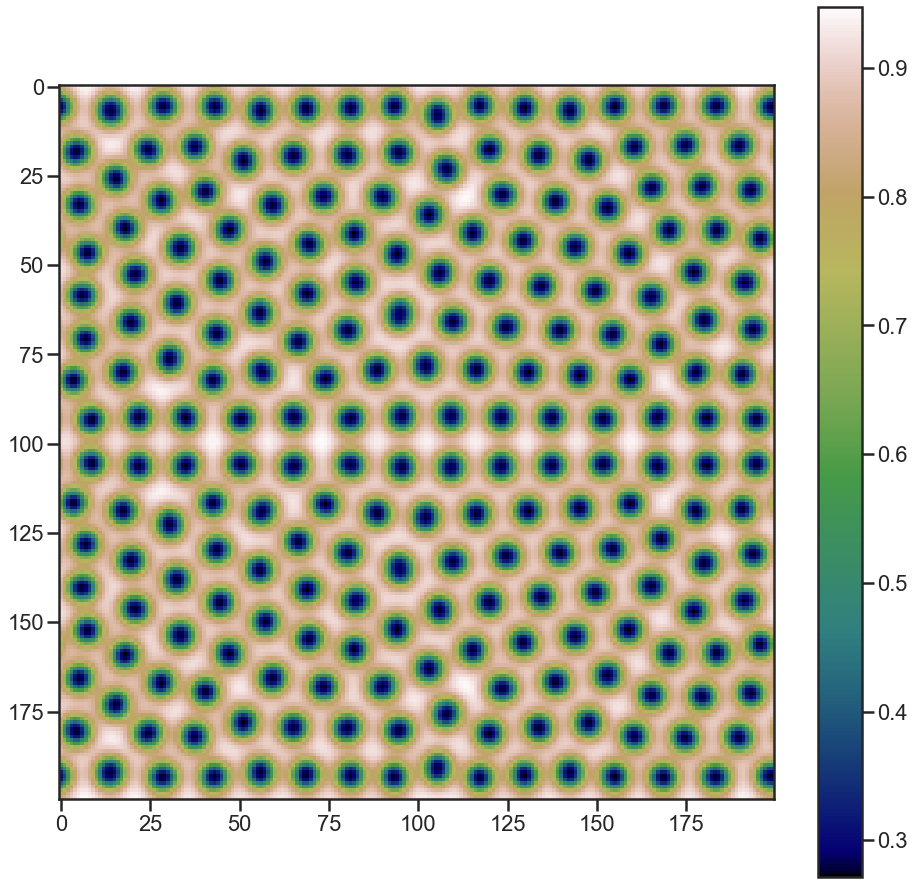

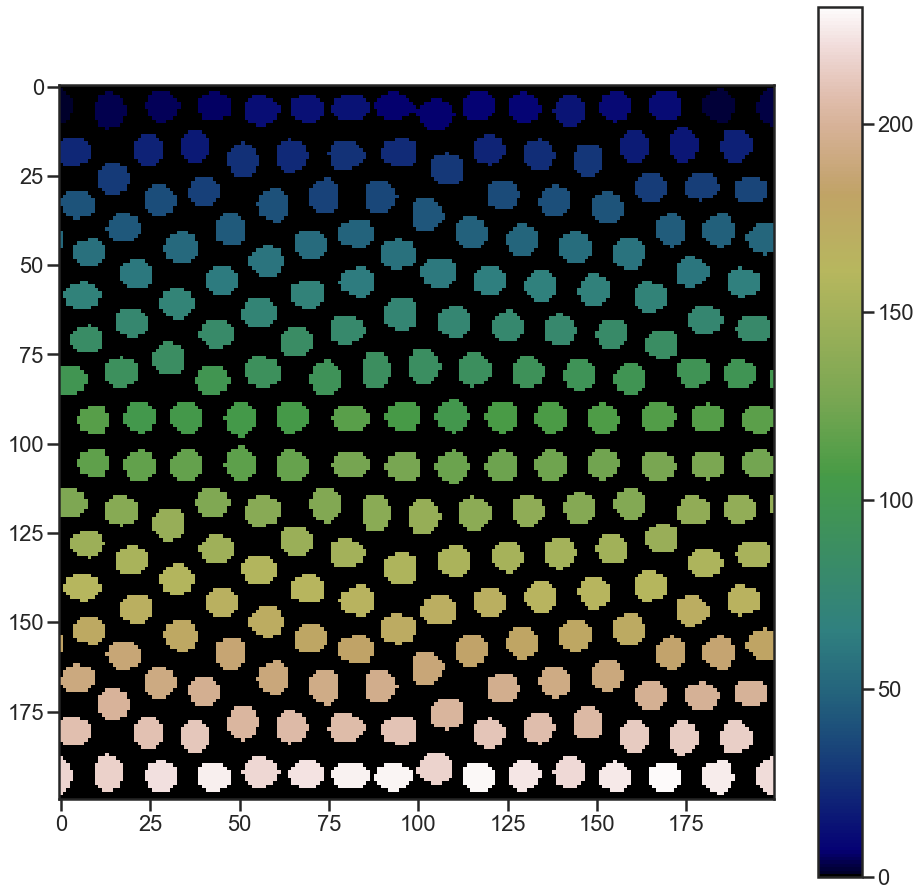

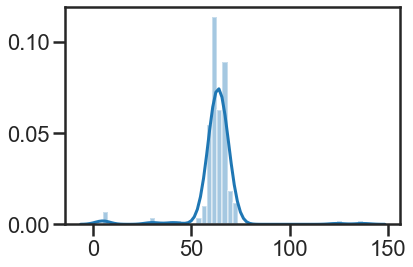

In [10]:
n = 200
Du = 0.16
Dv = 0.08
# F = 0.035
# k = 0.06
F = 0.0335
k = 0.0644
T = 40000
dt = 1.0
dx = 1.0


U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
r, m = n//40, n//2
U[...] = 1.0
V[m-r:m+r, m-r:m+r] = 0.25
V[m-r:m+r, m-r:m+r] = 0.5
u_out, v_out = gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

binarized = np.clip(preprocessing.scale(u_out)*-1000, 0, 1)
labels = ndimage.label(binarized)
bins, edges = np.histogram(labels[0], bins=labels[1])
plt.figure(figsize=(16,16))
plt.imshow(u_out, cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure(figsize=(16,16))
plt.imshow(labels[0], cmap='gist_earth')
plt.colorbar()
plt.show()
plt.figure()
sns.distplot(bins[1:])
plt.show()

In [11]:
from npfi import npfi, get_pdfs_from_data

# Compute g_ss for the Gaussian distribution
s = 1.0
ds = 0.1
N = 5000
rep = 30
analytic_value = 2.0 / s

FIMs_kde = []
FIMs_deft = []
epsilons_kde = []
epsilons_deft = []
for i in tqdm(range(rep)):
    Xa = np.random.normal(size=N, scale=s)
    Xb = np.random.normal(size=N, scale=s-ds)
    Xc = np.random.normal(size=N, scale=s+ds)

    pdfs_kde, bbox_kde = get_pdfs_from_data([bins[1:]], method="gaussian_kde")
    FIM_kde, int_err_kde, epsilon_kde = npfi(pdfs_kde, ds, N=N, bounds=bbox_kde, logarithmic=True)

    FIMs_kde.append(FIM_kde)
    epsilons_kde.append(FIM_kde)

print("#" * 50)
print("Estimation of the FI after %d repetitions:" % rep)
print("Analytic value: %.2f" % analytic_value)
print("FIM from KDE: %.3f, epsilon=%.3f" % (np.mean(FIMs_kde), np.mean(epsilon_kde)))
rel_kde = (np.mean(FIMs_kde) - analytic_value) / analytic_value
rel_kde_95 = (np.percentile(FIMs_kde, 95) - analytic_value) / analytic_value - rel_kde
rel_kde_5 = rel_kde - (np.percentile(FIMs_kde, 5) - analytic_value) / analytic_value
print("Relative error KDE: %.5f + %.5f - %.5f" % (rel_kde, rel_kde_95, rel_kde_5))
print("#" * 50)

AssertionError: 

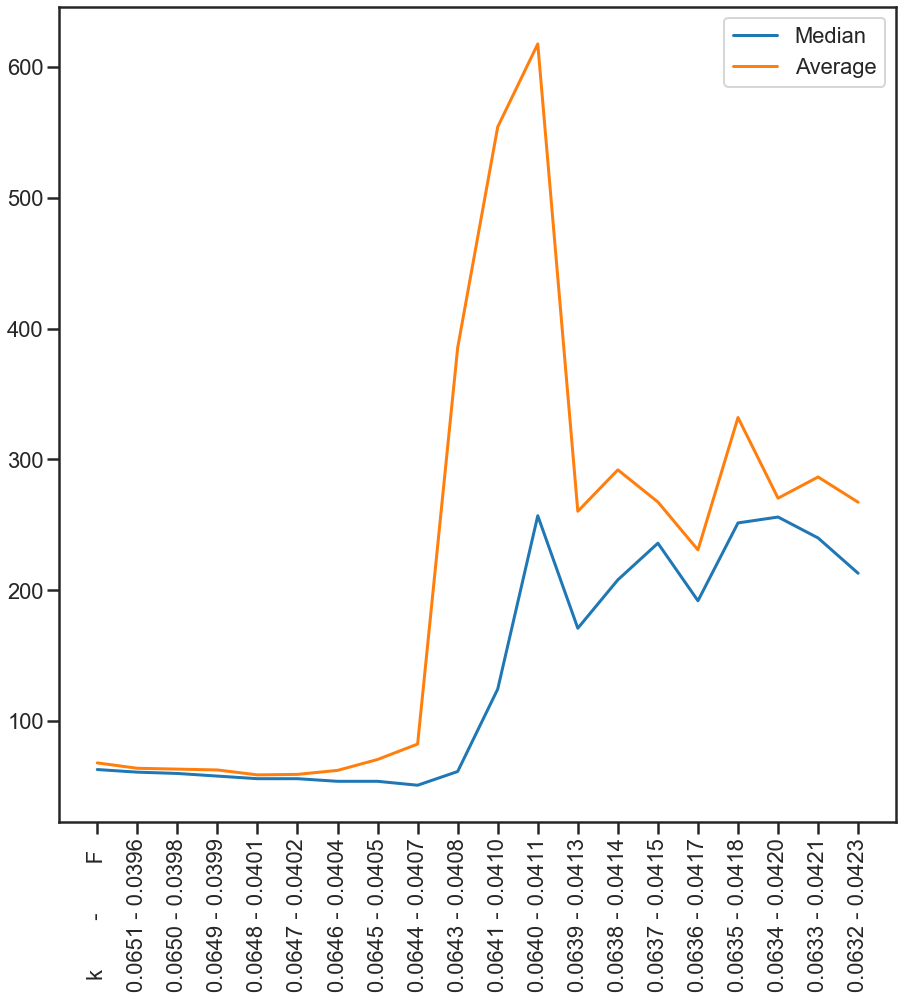

In [16]:
n = 200 #400
Du = 0.16
Dv = 0.08
# F = 0.035
# k = 0.06
F = 0.0335
k = 0.0644
T = 40000
dt = 1.0
dx = 1.0

rangesteps = 3 #20
k_range = np.linspace(0.0652, 0.0632, rangesteps)
F_range = np.linspace(0.0395, 0.04228, rangesteps)

medians = []
means = []
ticklabels = ["{0:.4f} - {1:.4f}".format(k_range[i], F_range[i]) for i in range(rangesteps)]
ticklabels[0] = "k        -        F  "

for i in tqdm(range(rangesteps)):
#     print(f"step {i}/{rangesteps}")
    k = k_range[i]
    F = F_range[i]
#     print(f"k = {k}, f = {F}")
    U, V = np.zeros((n, n), dtype=np.float64), np.zeros((n, n), dtype=np.float64)
    r, m = n//40, n//2
    U[...] = 1.0
    V[m-r:m+r, m-r:m+r] = 0.25
    V[m-r:m+r, m-r:m+r] = 0.5
    u_out, v_out = gray_scott(U, V, Du, Dv, F, k, dt, dx, T)

    binarized = np.clip(preprocessing.scale(u_out)*-1000, 0, 1)
    labels = ndimage.label(binarized)
    bins, edges = np.histogram(labels[0], bins=labels[1])
#     plt.figure()
#     sns.distplot(bins[1:])
#     plt.show()
#     print(f"average = {np.mean(bins[1:])}")
#     print(f"median = {np.median(bins[1:])}\n\n")
    medians.append(np.median(bins[1:]))
    means.append(np.mean(bins[1:]))
plt.figure(figsize=(15,15))
plt.plot(medians, label="Median")
plt.plot(means, label="Average")
plt.xticks(range(rangesteps), ticklabels, rotation='vertical')
plt.legend()
plt.show()

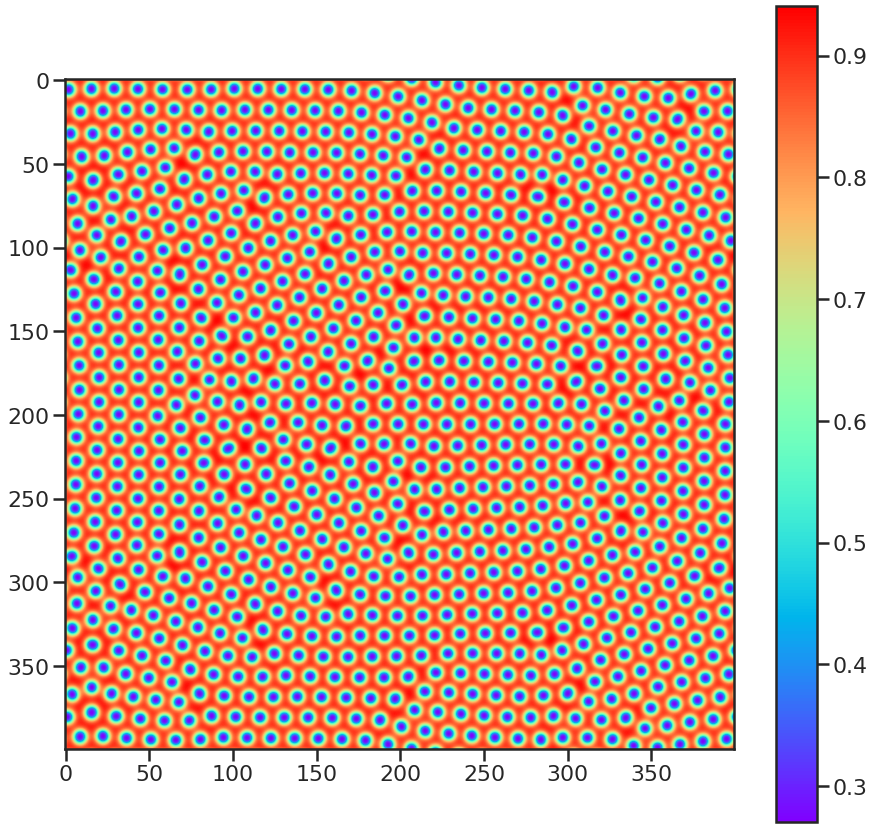

In [115]:
plt.figure(figsize=(15,15))
plt.imshow(u_out, cmap='rainbow', interpolation='lanczos')
plt.colorbar()
plt.show()

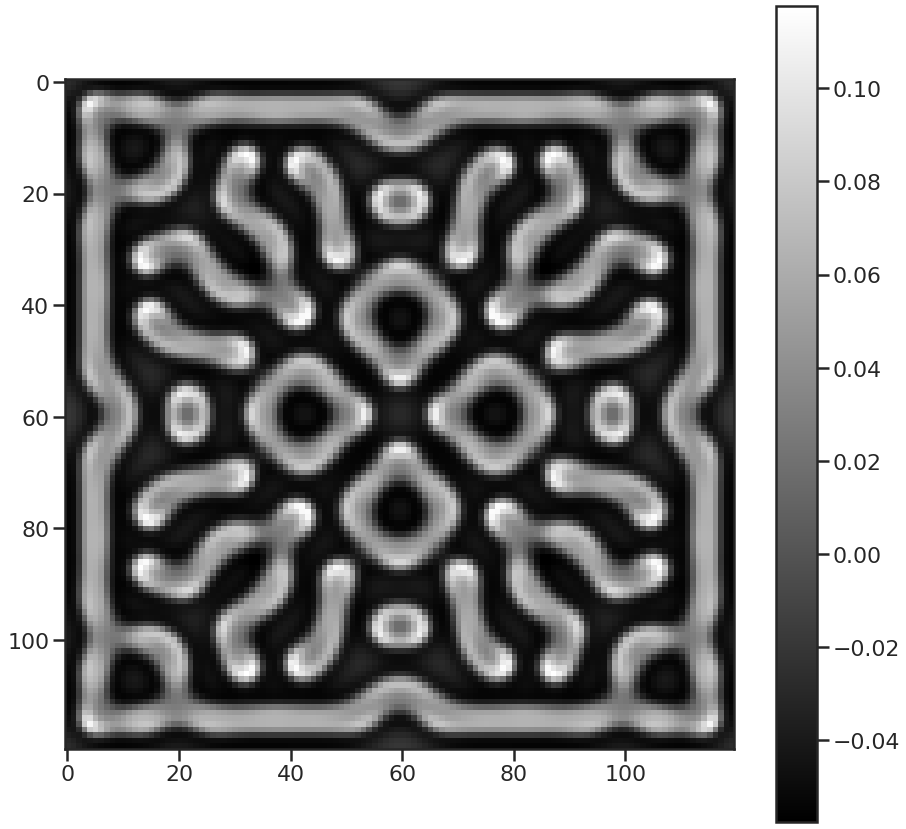

In [39]:
edge1 = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])
edge2 = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
edge3 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
plt.figure(figsize=(15,15))
plt.imshow(convolution(u_out, edge2, 1), cmap='gray')
plt.colorbar()
plt.show()

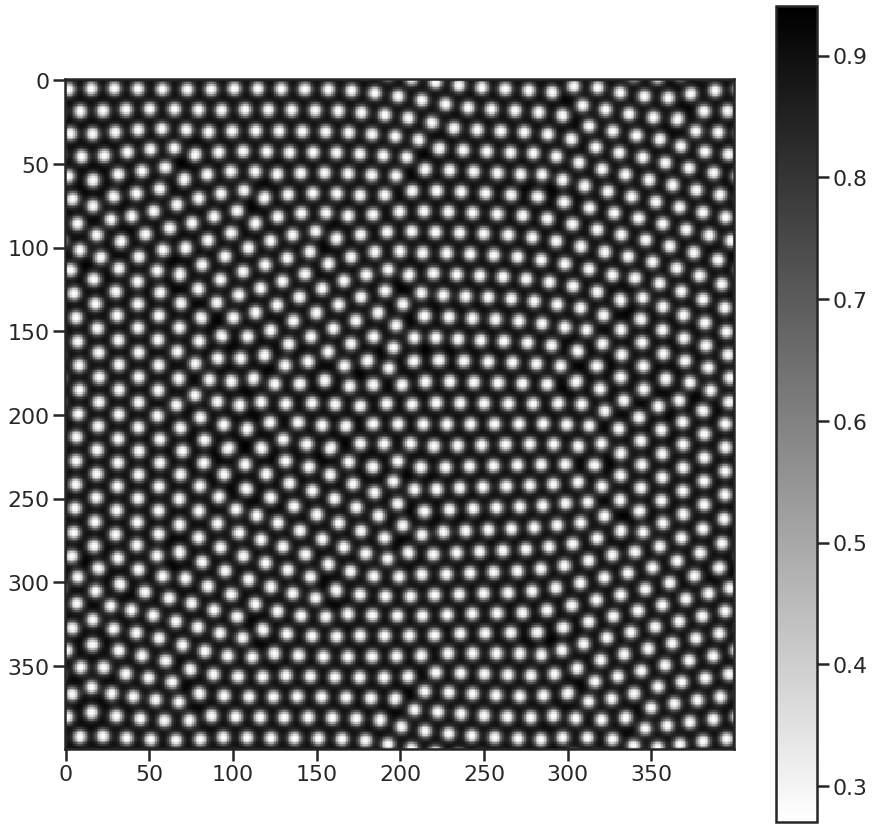

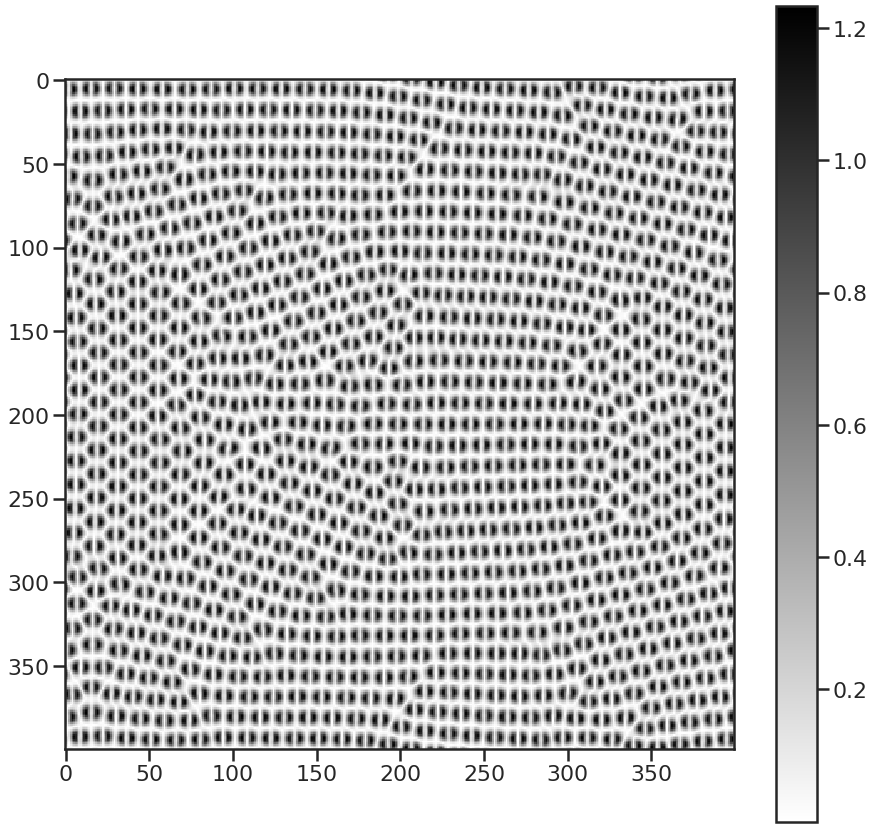

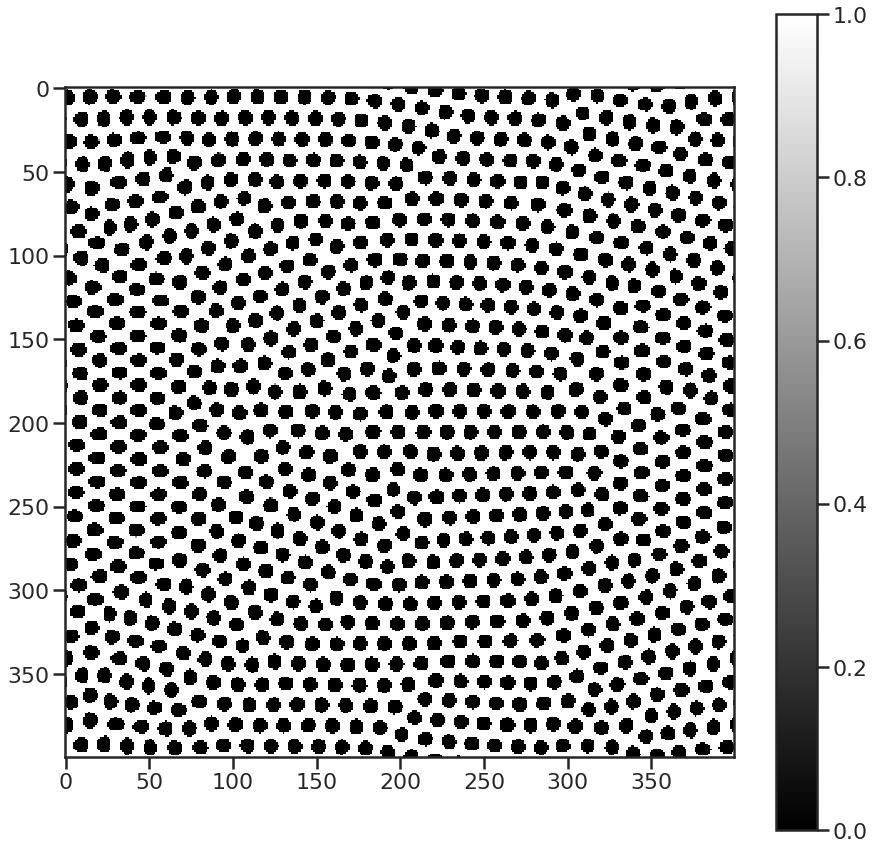

In [116]:
plt.figure(figsize=(15,15))
plt.imshow(u_out, cmap='binary')
plt.colorbar()
plt.show()

sobel1 = sobel(u_out, mode='wrap')

plt.figure(figsize=(15,15))
plt.imshow(np.abs(sobel1), cmap='binary')
plt.colorbar()
plt.show()

sobel2 = sobel(sobel(u_out, mode='wrap'))

plt.figure(figsize=(15,15))
plt.imshow(np.clip(preprocessing.scale(u_out)*1000, 0, 1), cmap='gray')
plt.colorbar()
plt.show()

binarized = np.clip(preprocessing.scale(u_out)*-1000, 0, 1)

In [19]:
np.sum(u_out)

8019.079052377486

In [117]:
labels = ndimage.label(binarized)

In [118]:
len(labels[0])

400

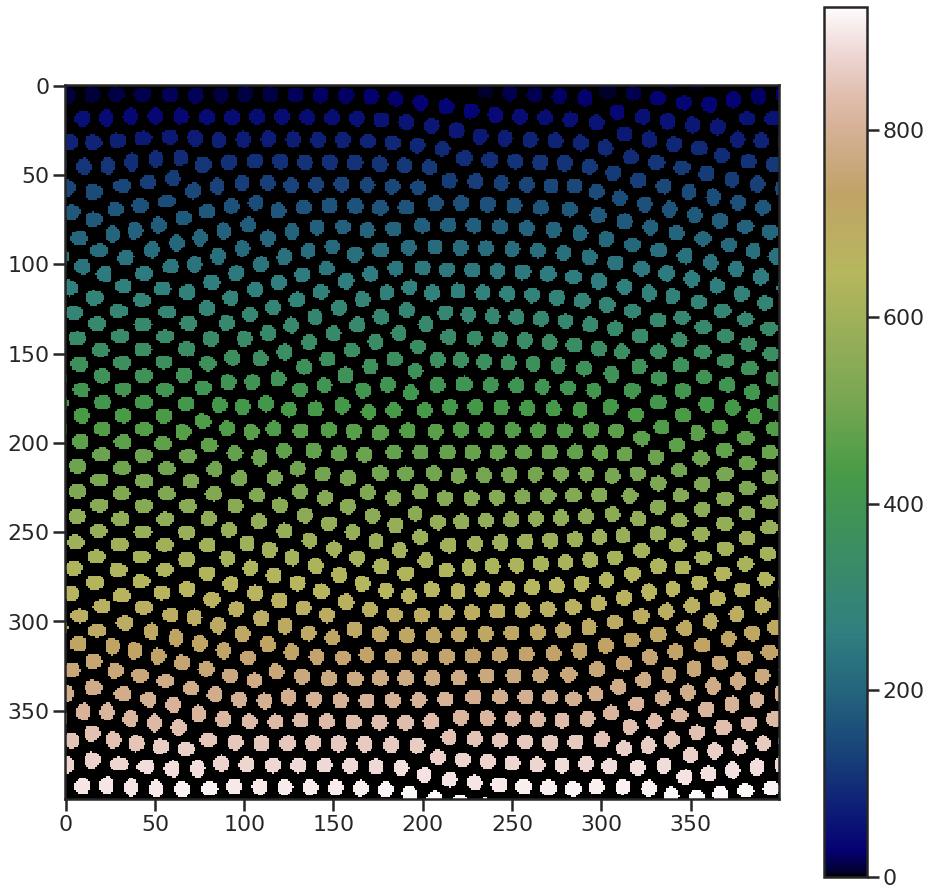

In [127]:
plt.figure(figsize=(16,16))
plt.imshow(labels[0], cmap='gist_earth')
plt.colorbar()
plt.show()

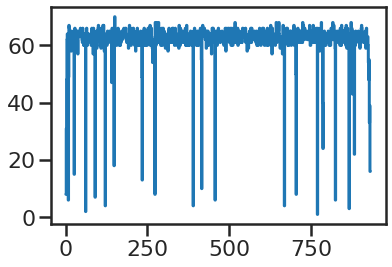

In [120]:
bins, edges = np.histogram(labels[0], bins=labels[1])
left,right = edges[:-1],edges[1:]
X = np.array([left,right]).T.flatten()
Y = np.array([bins,bins]).T.flatten()
plt.plot(X[2:], Y[2:])

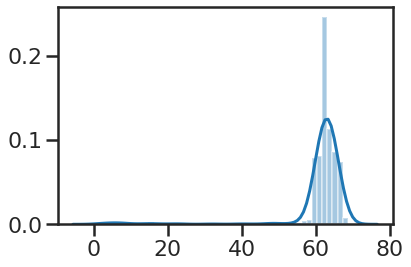

In [121]:
sns.distplot(bins[1:])

In [139]:
len(b)

42